# WhatsApp analysis

Uses:
- Seaborn visualization library
- Machine Learning via off the shelf transformers (we're not doing any learning here, just applying trained models)
- networkx

To visualize some key insights from a WhatsApp group chat

Used this as my starting point:
https://medium.com/analytics-vidhya/whatsapp-chat-analyze-visualize-68e4d30be729

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.pyplot import figure
from wordcloud import WordCloud

# Load and preprocess the messages

In [2]:
from preprocess import *

In [3]:
with open("data/whatsapp-chat.txt","r") as f: 
    data = f.readlines()
    
data_dict = merge_lines(data)
df = pd.DataFrame.from_dict(data_dict)

### Dates

In [4]:
df['parsed_date'] = pd.to_datetime(df.date)
df["day_of_week"] = df["parsed_date"].apply(lambda x: x.strftime('%a'))
day_of_week = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
df['day_of_week_idx'] = df.apply(lambda x: day_of_week[x.day_of_week],axis=1)
df["hour"] = df["time"].apply(lambda x: pd.to_datetime(x).hour)

### Roles

e.g. 'sender', 'joiner'

In [5]:
df[['sender','sent_msg']] = df.apply(message_sender,axis=1,result_type="expand")
df[['adder_person','added_people']] = df.apply(x_added_y,axis=1,result_type="expand")
df['leaver'] = df.apply(left,axis=1)
df['self_joiner'] = df.apply(joiner,axis=1)
df['other_joiners'] = df.apply(unspecified_joiner,axis=1)
df['disappearing_messages'] = df.apply(did_an_action,axis=1)


### Add ML content

In [6]:
from transformer_utils import *


In [7]:
df[["sentiment","sentiment_score"]] = df.apply(get_sentiment,axis=1,result_type="expand")
df[["locations","location_scores"]] = df.apply(get_locs,axis=1,result_type="expand")
df[["mentioned","mentioned_score"]] = df.apply(get_pers,axis=1,result_type="expand")

### What's left

In [8]:
unpreprocessed = df[(df.adder_person.isnull()) & (df.added_people.isnull()) &
                      (df.sender.isnull()) & (df.sent_msg.isnull()) & (df.leaver.isnull()) &
                      (df.self_joiner.isnull()) & (df.other_joiners.isnull()) & (df.disappearing_messages.isnull())
                 ]

print(f"{len(unpreprocessed)} rows of {len(df)} total rows were not handled")

8 rows of 1243 total rows were not handled


In [9]:
df[:6]

,date,time,msg,parsed_date,day_of_week,day_of_week_idx,hour,sender,sent_msg,adder_person,...,leaver,self_joiner,other_joiners,disappearing_messages,sentiment,sentiment_score,locations,location_scores,mentioned,mentioned_score
0,5/11/22,22:05,Messages and calls are end-to-end encrypted. N...,2022-05-11,Wed,3,22,None,None,None,...,None,None,None,None,None,NaN,[],[],[],[]
1,5/11/22,20:25,"Charlie created group ""TESTY TEST""",2022-05-11,Wed,3,20,None,None,None,...,None,None,None,None,None,NaN,[],[],[],[]
2,5/11/22,22:05,Charlie added George,2022-05-11,Wed,3,22,None,None,Charlie,...,None,None,None,None,None,NaN,[],[],[],[]
3,5/11/22,22:05,Bob added Brian,2022-05-11,Wed,3,22,None,None,Bob,...,None,None,None,None,None,NaN,[],[],[],[]
4,5/11/22,22:06,George is now an admin,2022-05-11,Wed,3,22,None,None,None,...,None,None,None,None,None,NaN,[],[],[],[]
5,5/11/22,22:06,Bob: U guys don’t need to add people…. George ...,2022-05-11,Wed,3,22,Bob,U guys don’t need to add people…. George is ad...,None,...,None,None,None,None,POSITIVE,0.990099,[],[],"[George, Frankie]","[0.9986191, 0.99863476]"


# Analysis

### Summary information

In [10]:
total_messages = df.shape[0]
number_of_days = (df["parsed_date"].max() - df["parsed_date"].min()).days + 1

print ("{:<32}: {}".format("Group formed", df["parsed_date"].min().date()))
print ("{:<32}: {}".format("Total Authors", df["sender"].nunique()))
print ("{:<32}: {}".format("Total messages", total_messages))
print ("{:<32}: {}".format("Number of days", number_of_days))
print ("{:<32}: {}".format("Avg. messages sent every day", round(total_messages/number_of_days, 2)))

Group formed                    : 2022-05-11
Total Authors                   : 136
Total messages                  : 1243
Number of days                  : 8
Avg. messages sent every day    : 155.38


### Heatmap

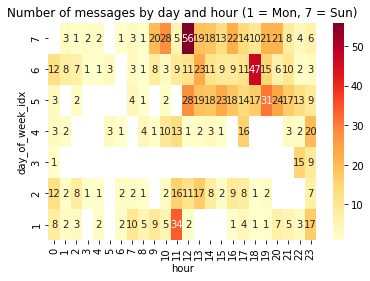

In [11]:
msgs_only_df = df[~df.sent_msg.isnull()]
msgs_by_time = msgs_only_df.groupby(['hour', 'day_of_week_idx'], as_index=False)["msg"].count()
msgs_by_time_pivot = msgs_by_time.pivot(index="day_of_week_idx",columns="hour",values="msg",)
#figure(figsize=(6, 6), dpi=100)
ax = sns.heatmap(msgs_by_time_pivot,annot=True,cmap="YlOrRd")
ax.set_title('Number of messages by day and hour (1 = Mon, 7 = Sun)')
ax.invert_yaxis()
plt.show()

### Top message senders

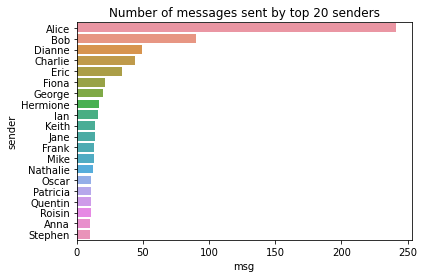

In [12]:
num_senders = 20
msgs_by_sender = msgs_only_df.groupby(['sender'], as_index=False)["msg"].count()
top_senders = msgs_by_sender.nlargest(num_senders,columns="msg").sort_values(by="msg",ascending=False)
#figure(figsize=(7, 7), dpi=200)
ax = sns.barplot(x="msg",y="sender",data=top_senders)
ax.set_title(f"Number of messages sent by top {num_senders} senders")
plt.show()

## Sentiment

Using https://huggingface.co/siebert/sentiment-roberta-large-english

In [13]:
sentiment_count = msgs_only_df[["sender","sentiment"]].pivot_table(index=["sender","sentiment"],aggfunc = lambda x: len(x)).reset_index()
sentiment_count.columns=["sender","sentiment","count"]

In [14]:
sent_pivot = sentiment_count.pivot(index="sender",columns="sentiment",values="count").fillna(0).reset_index()
top_sender_sentiment = sent_pivot[sent_pivot.sender.isin(top_senders.sender)]
#top_sender_sentiment

<AxesSubplot:xlabel='NEGATIVE', ylabel='sender'>

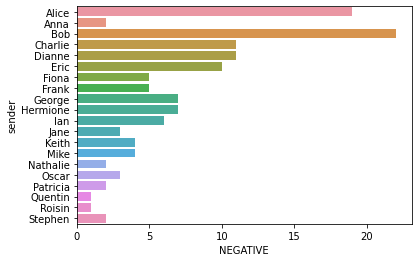

In [15]:
sns.barplot(y="sender",x="NEGATIVE",data=top_sender_sentiment)

<AxesSubplot:xlabel='POSITIVE', ylabel='sender'>

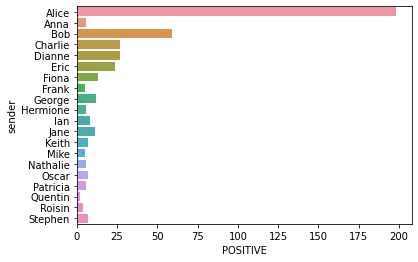

In [16]:
sns.barplot(y="sender",x="POSITIVE",data=top_sender_sentiment)

In [17]:
sent_score_df = msgs_only_df.fillna(0).groupby(["sender"],as_index=False)["sentiment_score"].mean()
sent_score_df = sent_score_df[sent_score_df.sender.isin(top_senders.sender)]

<AxesSubplot:xlabel='sentiment_score', ylabel='sender'>

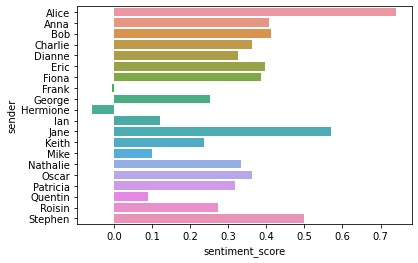

In [18]:
sns.barplot(y="sender",x="sentiment_score",data=sent_score_df)

## Named Entity Recognition

### Geography

Using https://huggingface.co/dslim/bert-base-NER

In [19]:
locations_list = df[~df.locations.isnull()].locations.tolist()
flat1 = [" ".join(x) for x in locations_list]
flat2 = " ".join(flat1)

(-0.5, 399.5, 199.5, -0.5)

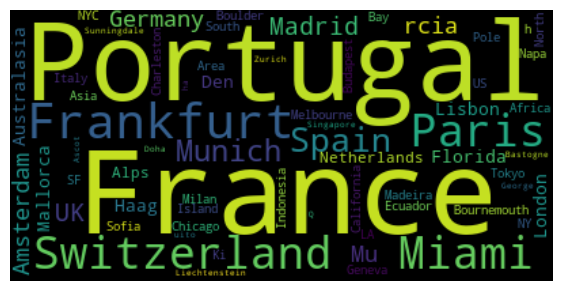

In [20]:
wordcloud = WordCloud().generate(flat2)
figure(figsize=(7, 7), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Mentioned People

(-0.5, 399.5, 199.5, -0.5)

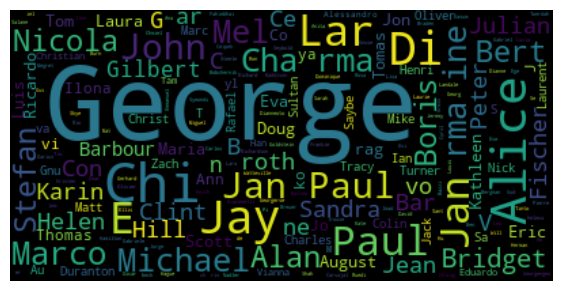

In [21]:
mentioned_list = df[~df.mentioned.isnull()].mentioned.tolist()
flat1 = [" ".join(x) for x in mentioned_list]
flat2 = " ".join(flat1)
wordcloud = WordCloud().generate(flat2)
figure(figsize=(7, 7), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


## Network

In [22]:
adders_only_df = df[~df.adder_person.isnull()][["adder_person","added_people"]]

In [23]:
adders = {}

for x, ys in adders_only_df[["adder_person","added_people"]].itertuples(index=False):
    if x in adders:
        adders[x].extend(ys)
    else:
        adders[x] = ys 

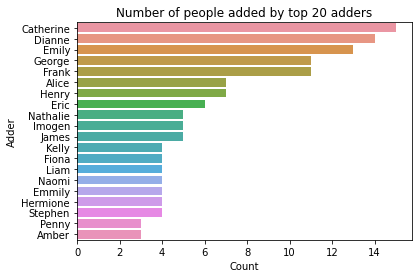

In [24]:
num_largest = 20
adder_counts = [(k,len(v)) for k,v in adders.items() ]
adder_count_df = pd.DataFrame(adder_counts,columns=["Adder","Count"])
#figure(figsize=(5, 5), dpi=100)
ax = sns.barplot(x="Count",y="Adder",data=adder_count_df.nlargest(num_largest,"Count"))
ax.set_title(f"Number of people added by top {num_largest} adders")
plt.show()

In [25]:
FullG = nx.DiGraph()

top_sender_list = top_senders.sender.tolist()
FullG.add_nodes_from(top_sender_list)

for x,ys in adders_only_df[["adder_person","added_people"]].itertuples(index=False):
    for y in ys:
        FullG.add_edge(x,y)

predecessors = [list(FullG.predecessors(x)) for x in top_sender_list if x in FullG]
predecessors = [x for sublist in predecessors for x in sublist]

def filter_node(n):
    if n in top_sender_list or n in predecessors:
        return True
    else:
        return False
    
G = nx.subgraph_view(FullG,filter_node=filter_node)

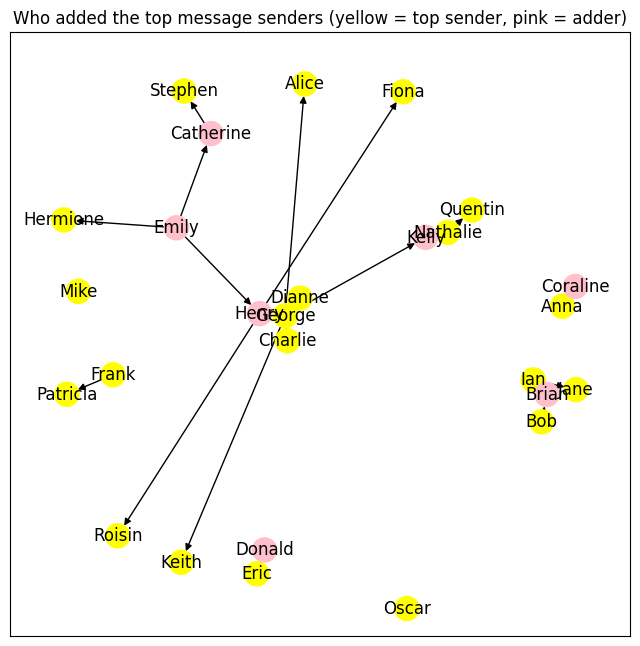

In [26]:
figure(figsize=(8, 8), dpi=100)

cnt_top = 0

colormap = []
for node in G:
    if node in top_sender_list:
        cnt_top +=1
        colormap.append('Yellow')
    else:
        colormap.append('Pink')
            
#print(f"{cnt_top} top senders found")
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos,node_color=colormap)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
plt.title("Who added the top message senders (yellow = top sender, pink = adder)")
plt.show()